<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v12b_OutputGradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v12 - asside (b): Collecting output gradients while training
In continuing the implementation of the near-zero gradient explainer, I've realised that I should just extend the existing custom training loop to collect the gradients w.r.t. layer outputs. This makes everything so much simpler.

In [18]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout 704ef35
!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
import train_explainer as te
import matmul_explainer as me
from importlib import reload
reload(tot)
reload(te)
reload(me)

HEAD is now at 0872da3 Merge remote-tracking branch 'refs/remotes/origin/main'
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 4), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 1.43 KiB | 163.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   0872da3..9910de1  main       -> origin/main
Updating 0872da3..9910de1
Fast-forward
 train_observability_toolkit.py | 76 +++++++++++++++++++++++++++++++++++++++++++++-----------------
 1 file changed, 56 insertions(+), 20 deletions(-)


<module 'matmul_explainer' from '/content/repo/matmul_explainer.py'>

In [4]:
import train_observability_toolkit_test
import train_explainer_test
import matmul_explainer_test
reload(matmul_explainer_test)
reload(train_explainer_test)
reload(train_observability_toolkit_test)
reload(tot)
reload(me)
reload(te)
train_observability_toolkit_test.run_test_suite()
matmul_explainer_test.run_test_suite()
train_explainer_test.run_test_suite()

All train_observability_toolkit tests passed.
All matmul_explainer tests passed.
All train_explainer tests passed.


In [5]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic Setup

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


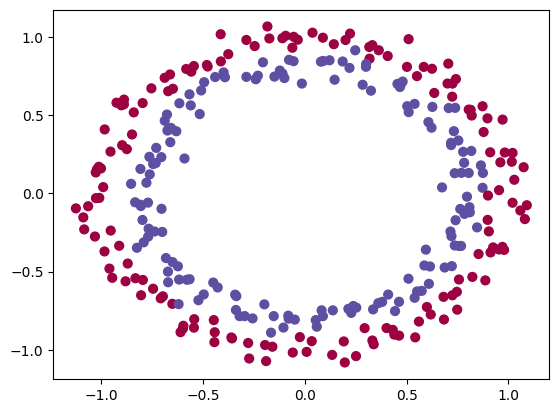

In [6]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

## Temporary: Custom training loop

In [19]:
# Tries to replicate keras.backend.tensorflow.TensorFlowTrainer.fit() (trainer.py, keras 3.5.0)
# as much as possible.
from train_observability_toolkit import BaseGradientCallback
def fit(model, dataset, epochs=1, verbose=1, callbacks=None, initial_epoch=0):
    """
    A custom training loop mimicking model.fit() that makes raw gradient and layer output
    information available for tracking.

    Honours the state of `tf.config.run_functions_eagerly(bool)`.

    Args:
        model: usual meaning
        dataset: usual meaning, except only copes with fixed-length datasets
        epochs: usual meaning
        verbose: usual meaning
        callbacks: usual meaning plus can take instances of BaseGradientCallback
        initial_epoch: usual meaning
    Returns:
         HistoryCallback
    """
    # prepare epochs
    num_batches = len(dataset)

    # prepare callbacks tracking
    gradient_callbacks = []
    if callbacks is not None and not isinstance(callbacks, tf.keras.callbacks.CallbackList):
        gradient_callbacks = [callback for callback in callbacks if isinstance(callback, BaseGradientCallback)]
        callbacks = [callback for callback in callbacks if not isinstance(callback, BaseGradientCallback)]
    if not isinstance(callbacks, tf.keras.callbacks.CallbackList):
        callbacks = tf.keras.callbacks.CallbackList(callbacks, add_history=True, add_progbar=verbose != 0,
                                                    verbose=verbose, epochs=epochs, steps=num_batches, model=model)
    for gradient_callback in gradient_callbacks:
        gradient_callback.set_params({'epochs': epochs, 'steps': len(dataset)})
        gradient_callback.set_model(model)

    needs_output_gradients = True
    #for gradient_callback in gradient_callbacks:
    #    needs_output_gradients = needs_output_gradients and gradient_callback.needs_output_gradients()

    # prepare model for layer output collection
    # (original model output(s) will be first entry of new outputs array, it will have single tensor or list
    # accordingly)
    monitoring_model = tf.keras.Model(
        inputs=model.inputs,
        outputs=[model.outputs] + [layer.output for layer in model.layers])

    # prepare train function
    if tf.config.functions_run_eagerly():
        train_step_fn = _gradient_returning_train_step
    else:
        train_step_fn = tf.function(_gradient_returning_train_step)

    # train
    logs = {}  # holds latest value at any given moment in time
    loss = None
    gradients = None
    activations = None
    callbacks.on_train_begin()
    for gradient_callback in gradient_callbacks:
        gradient_callback.on_train_begin()
    for epoch in range(initial_epoch, epochs):
        model.reset_metrics()
        start = tf.timestamp()
        callbacks.on_epoch_begin(epoch)
        for gradient_callback in gradient_callbacks:
            gradient_callback.on_epoch_begin(epoch)

        for step, data in enumerate(dataset):
            x, y, sample_weight = keras.utils.unpack_x_y_sample_weight(data)
            callbacks.on_train_batch_begin(step)
            for gradient_callback in gradient_callbacks:
                gradient_callback.on_train_batch_begin(step)

            loss, metrics, trainable_gradients, output_gradients, activations = train_step_fn(model, monitoring_model, x, y, sample_weight, needs_output_gradients)
            if output_gradients is not None:
              print(f"layer_gradients {len(output_gradients)}, {[l.shape if l is not None else 'None' for l in output_gradients]}")

            logs = metrics
            logs['loss'] = loss.numpy()
            callbacks.on_train_batch_end(step, logs)
            for gradient_callback in gradient_callbacks:
                gradient_callback.on_train_batch_end(step, loss, gradients, model.trainable_variables, activations)

        # end of epoch
        dur = (tf.timestamp() - start).numpy()
        callbacks.on_epoch_end(epoch, logs)  # should be passing loss and mse
        for gradient_callback in gradient_callbacks:
            gradient_callback.on_epoch_end(epoch, loss, gradients, model.trainable_variables, activations)
        metric_str = ''
        for k in logs.keys():
            metric_str += f" - {k}: {logs[k]:.3f}"
    callbacks.on_train_end(logs)
    for gradient_callback in gradient_callbacks:
        gradient_callback.on_train_end()

    return model.history


# Tries to replicate keras.backend.tensorflow.TensorFlowTrainer.train_step() (trainer.py, keras 3.5.0)
# as much as possible.
def _gradient_returning_train_step(model, monitoring_model, x, y, sample_weight, compute_output_gradients):
    """
    This method is programmatically converted via auto-graph.

    Returns:
        loss: float. Loss returned by loss function (before optimizer scaling).
        metrics: dict. Metrics returned by model (note: also includes a 'loss' value but it's always zero)
        gradients: list. Gradients tensor for each trainable variable
    """

    # Forward pass
    with tf.GradientTape() as tape:
        monitoring_outputs = monitoring_model(x)
        y_pred = monitoring_outputs[0]
        layer_outputs = monitoring_outputs[1:]

        loss = model.compute_loss(x=x, y=y, y_pred=y_pred, sample_weight=sample_weight, training=True)
        reported_loss = loss  # tracking before scaling
        loss = model.optimizer.scale_loss(loss)

    # Backward pass
    if compute_output_gradients:
        gradients = tape.gradient(loss, model.trainable_weights + layer_outputs)
        trainable_grads = gradients[:len(model.trainable_variables)]
        output_grads = gradients[len(model.trainable_variables):]
    else:
        trainable_grads = tape.gradient(loss, model.trainable_variables)
        output_grads = None
    model.optimizer.apply_gradients(zip(trainable_grads, model.trainable_variables))

    # Metrics
    metrics = model.compute_metrics(x=x, y=y, y_pred=y_pred, sample_weight=sample_weight)

    return reported_loss, metrics, trainable_grads, output_grads, layer_outputs


# do tarining
reload(tot)
tf.config.run_functions_eagerly(False)
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=2)
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.7018
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6869 
Total training time: 2.79 secs


## Collect and display data

In [ ]:
# This will take a couple of minutes to run
reload(tot)
collection_sets = [{'include_non_trainable': True}]
variables = tot.VariableHistoryCallback(per_step=True, before_updates=True, collection_sets=collection_sets)
gradients = tot.GradientHistoryCallback(per_step=True, collection_sets=collection_sets)
activity = tot.ActivityHistoryCallback(per_step=True, collection_sets=collection_sets)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=20, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)